## Mischportfolio zwischen hebel und non Lev und mit Gold + Cash + Bonuszertfikaten im Crash

         Date  SPX Close  SPX Open  SPX High  SPX Low  Nasdaq Close  \
0  01/30/2012    2256.72   2256.72   2256.72  2256.72        2596.2   
1  01/31/2012    2255.69   2255.69   2255.69  2255.69        2617.5   
2  02/01/2012    2276.24   2276.24   2276.24  2276.24        2625.5   
3  02/02/2012    2278.92   2278.92   2278.92  2278.92        2661.6   
4  02/03/2012    2312.49   2312.49   2312.49  2312.49        2660.9   

   Nasdaq Open  Nasdaq High  Nasdaq Low    Gold  ...  Nas Ret 2x  SPX Ret 3x  \
0       2605.4       2610.5      2580.5  1680.6  ...         NaN         NaN   
1       2610.6       2627.1      2602.9  1660.2  ...    0.016409   -0.001369   
2       2624.8       2634.3      2616.4  1649.7  ...    0.006113    0.027331   
3       2650.8       2664.9      2646.7  1651.1  ...    0.027500    0.003532   
4       2651.4       2660.9      2645.3  1639.6  ...   -0.000526    0.044192   

   Nas Ret 3x  SPX Ret 4x  Nas Ret 4x  SPX Ret 5x  Nas Ret 5x  Nas Lever  \
0         NaN   

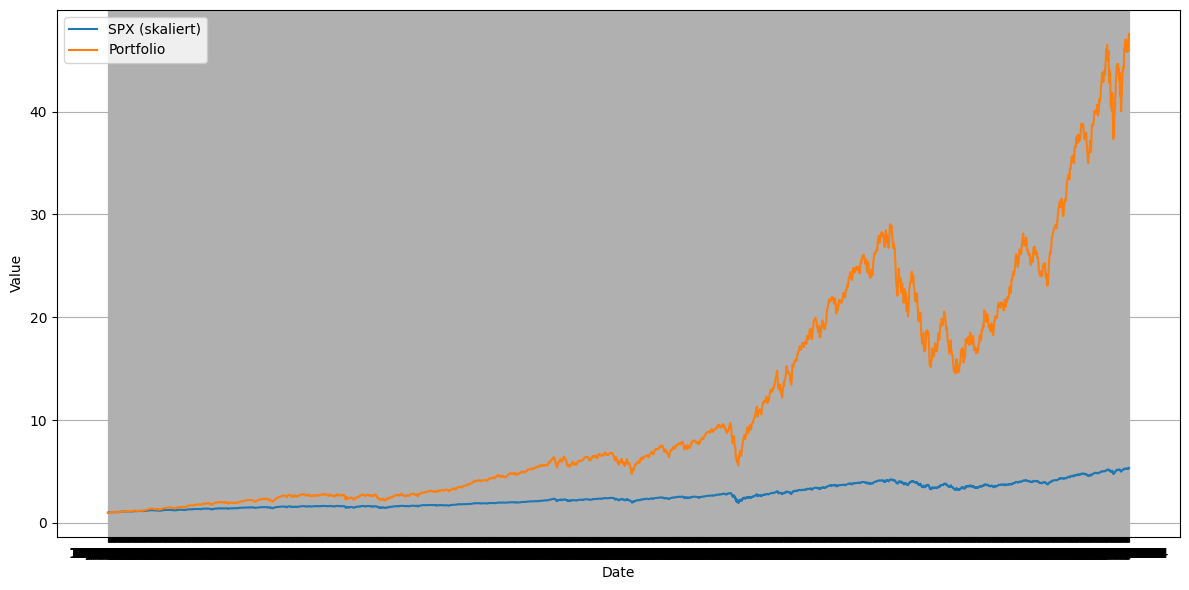

Final Portfolio Value: 47.54682928177165
         Date  SPX Close  SPX Open  SPX High  SPX Low  Nasdaq Close  \
0  01/30/2012    2256.72   2256.72   2256.72  2256.72        2596.2   
1  01/31/2012    2255.69   2255.69   2255.69  2255.69        2617.5   
2  02/01/2012    2276.24   2276.24   2276.24  2276.24        2625.5   
3  02/02/2012    2278.92   2278.92   2278.92  2278.92        2661.6   
4  02/03/2012    2312.49   2312.49   2312.49  2312.49        2660.9   

   Nasdaq Open  Nasdaq High  Nasdaq Low    Gold  ...  Nas Ret 2x  SPX Ret 3x  \
0       2605.4       2610.5      2580.5  1680.6  ...         NaN         NaN   
1       2610.6       2627.1      2602.9  1660.2  ...    0.016409   -0.001369   
2       2624.8       2634.3      2616.4  1649.7  ...    0.006113    0.027331   
3       2650.8       2664.9      2646.7  1651.1  ...    0.027500    0.003532   
4       2651.4       2660.9      2645.3  1639.6  ...   -0.000526    0.044192   

   Nas Ret 3x  SPX Ret 4x  Nas Ret 4x  SPX Ret 5x  

In [701]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten einlesen und umkehren
df = pd.read_csv('data/All Historical Data.csv', sep=';', quotechar='"', thousands=',')
df = df.iloc[::-1].reset_index(drop=True)

# Renditen berechnenCrypto 5%
df['EM Return']    = df['EM Close'].pct_change() + 0.00011
df['Stoxx Return'] = df['Stoxx 50 Close'].pct_change() * 2 + 0.00016
df['SPX Return']   = df['SPX Close'].pct_change()
df['Gold Return']  = df['Gold'].pct_change()

# Basis- und Bonusrenditen
df['Base Return']  = df['SPX Return'] * 0.25 + df['Stoxx Return'] * 0.4 + df['EM Return'] * 0.55
df['Bonus Return'] = 0.8 * df['SPX Return'] + 0.0004
# Bear Case praktisch
df['Bear Return']  = df['Gold Return'] * 0.3 + df['Bonus Return'] * 0.4 + 0.0001 * 0.3

# 200-Tage-Durchschnitte und Linien
for idx in ['SPX', 'Nasdaq']:
    df[f'{idx} MA200'] = df[f'{idx} Close'].rolling(200).mean()
    df[f'{idx} Sell']  = 0.99 * df[f'{idx} MA200']
    df[f'{idx} Buy']   = 0.98 * df[f'{idx} MA200']

# Hebel-Renditen
for lev in [2, 3, 4, 5]:
    df[f'SPX Ret {lev}x'] = df['SPX Return'] * lev
    df[f'Nas Ret {lev}x'] = df['Nasdaq Close'].pct_change() * lev

# Hebel-Portfolios
df['Nas Lever'] = (df['Nas Ret 2x'] * 0.18
                  + df['Nas Ret 3x'] * 0.73
                  + df['Nas Ret 4x'] * 0.06
                  + df['Nas Ret 5x'] * 0.03)
df['SPX Lever'] = (df['SPX Ret 2x'] * 0.5
                  + df['SPX Ret 3x'] * 0.5)

# Initialisierung der Simulation
state_spx      = 'bull'
state_nas      = 'bull'
port_val       = 1.0
trading_weight = 0.6
weight_spx     = 0.5  # Anteil SPX im Trading-Teil
weight_nas     = 0.5  # Anteil Nasdaq im Trading-Teil
special_bear   = False  # Flag für 100% Bonus-Zertifikat

df['Portfolio'] = pd.NA

# Startwerte für dynamische Linien
spx_buy, spx_sell = df.loc[199, 'SPX Buy'], df.loc[199, 'SPX Sell']
nas_buy, nas_sell = df.loc[199, 'Nasdaq Buy'], df.loc[199, 'Nasdaq Sell']

# Simulationsschleife
for i in range(200, len(df)):
    prev  = df.iloc[i-1]
    today = df.iloc[i]

    # Spezial-Bear-Trigger: SPX fällt 20% unter MA200
    if not special_bear and today['SPX Close'] < 0.8 * today['SPX MA200']:
        special_bear = True
    # Rücksetzen, sobald Bull Case (SPX zurück über Sell-Line)
    if special_bear and prev['SPX Close'] < prev['SPX Sell'] and today['SPX Close'] > today['SPX Sell'] and today['SPX Low'] > today['SPX Sell']:
        special_bear = False

    # Dynamische Linien
    if prev['SPX Close'] > spx_sell and today['SPX Low'] < spx_sell:
        spx_buy = spx_sell
    if prev['SPX Close'] < spx_buy and today['SPX High'] > spx_buy:
        spx_sell = spx_buy
    if prev['Nasdaq Close'] > nas_sell and today['Nasdaq Low'] < nas_sell:
        nas_buy = nas_sell
    if prev['Nasdaq Close'] < nas_buy and today['Nasdaq High'] > nas_buy:
        nas_sell = nas_buy

    # SPX Return-Berechnung
    lever_spx = df.at[i, 'SPX Lever']
    bear_ret  = df.at[i, 'Bear Return']
    if prev['SPX Close'] > spx_sell and today['SPX Close'] > spx_sell and today['SPX Low'] > spx_sell:
        spx_ret = lever_spx
        new_state_spx = 'bull'
    elif prev['SPX Close'] < spx_buy and today['SPX Close'] < spx_buy and today['SPX High'] < spx_buy:
        spx_ret = bear_ret
        new_state_spx = 'bear'
    elif prev['SPX Close'] < spx_buy and today['SPX High'] > spx_buy:
        if today['SPX Close'] > spx_buy and today['SPX High'] <= spx_buy * 1.005:
            spx_ret = bear_ret
            new_state_spx = 'bear'
        elif today['SPX High'] > spx_buy * 1.005:
            if today['SPX Close'] >= spx_buy * 1.005:
                r1      = spx_buy * 1.005 / prev['SPX Close'] - 1
                raw     = today['SPX Close'] / prev['SPX Close'] - 1
                L       = lever_spx / raw if raw != 0 else 1
                r2      = today['SPX Close'] / (spx_buy * 1.005) - 1
                spx_ret = r1 + r2 * L
            else:
                spx_ret = -0.01
            new_state_spx = 'bull' if today['SPX Close'] >= spx_buy * 1.005 else 'bear'
    elif prev['SPX Close'] > spx_sell and today['SPX Low'] < spx_sell:
        if today['SPX Low'] >= spx_sell * 0.995 and today['SPX Close'] < spx_sell:
            spx_ret = lever_spx
        elif today['SPX Low'] < spx_sell * 0.995:
            if today['SPX Close'] < spx_sell:
                spx_ret = 3 * (spx_sell * 0.995 / prev['SPX Close'] - 1)
            else:
                spx_ret = -0.01
        new_state_spx = 'bear'
    else:
        spx_ret = bear_ret
        new_state_spx = state_spx

    # Nasdaq Return-Berechnung
    lever_nas = df.at[i, 'Nas Lever']
    raw_nas   = today['Nasdaq Close'] / prev['Nasdaq Close'] - 1
    L_nas     = lever_nas / raw_nas if raw_nas != 0 else 1
    if prev['Nasdaq Close'] > nas_sell and today['Nasdaq Close'] > nas_sell and today['Nasdaq Low'] > nas_sell:
        nas_ret = lever_nas
        new_state_nas = 'bull'
    elif prev['Nasdaq Close'] < nas_buy and today['Nasdaq Close'] < nas_buy and today['Nasdaq High'] < nas_buy:
        nas_ret = bear_ret
        new_state_nas = 'bear'
    elif prev['Nasdaq Close'] < nas_buy and today['Nasdaq High'] > nas_buy:
        if today['Nasdaq Close'] > nas_buy and today['Nasdaq High'] <= nas_buy * 1.005:
            nas_ret = bear_ret
            new_state_nas = 'bear'
        elif today['Nasdaq High'] > nas_buy * 1.005:
            if today['Nasdaq Close'] >= nas_buy * 1.005:
                r1     = nas_buy * 1.005 / prev['Nasdaq Close'] - 1
                r2     = today['Nasdaq Close'] / (nas_buy * 1.005) - 1
                nas_ret = r1 + r2 * L_nas
            else:
                nas_ret = -0.01
            new_state_nas = 'bull' if today['Nasdaq Close'] >= nas_buy * 1.005 else 'bear'
    elif prev['Nasdaq Close'] > nas_sell and today['Nasdaq Low'] < nas_sell:
        if today['Nasdaq Low'] >= nas_sell * 0.995 and today['Nasdaq Close'] < nas_sell:
            nas_ret = lever_nas
        elif today['Nasdaq Low'] < nas_sell * 0.995:
            if today['Nasdaq Close'] < nas_sell:
                nas_ret = 3 * (nas_sell * 0.995 / prev['Nasdaq Close'] - 1)
            else:
                nas_ret = -0.01
        new_state_nas = 'bear'
    else:
        nas_ret = bear_ret
        new_state_nas = state_nas

    # Trading-Return bestimmen (Special Bear override)
    if special_bear:
        trading_ret = weight_spx * spx_ret + weight_nas * nas_ret
    else:
        trading_ret = weight_spx * spx_ret + weight_nas * nas_ret

    # Gesamt-Return und Portfolio-Wert
    base_ret = today['Base Return']
    port_ret = (1 - trading_weight) * base_ret + trading_weight * trading_ret
    port_val *= 1 + port_ret
    df.at[i, 'Portfolio'] = port_val

    # Zustände aktualisieren
    state_spx = new_state_spx
    state_nas = new_state_nas

print(df.head())
print(df.tail())

# Plot
valid = df['Portfolio'].notna()
spx_scaled = df.loc[valid, 'SPX Close'] / df.loc[valid, 'SPX Close'].iloc[0]
plt.figure(figsize=(12, 6))
plt.plot(df.loc[valid, 'Date'], spx_scaled, label='SPX (skaliert)')
plt.plot(df.loc[valid, 'Date'], df.loc[valid, 'Portfolio'].astype(float), label='Portfolio')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Endwert ausgeben
print('Final Portfolio Value:', port_val)

import matplotlib.pyplot as plt

# Nur gültige Werte plotten
valid_rows = df['Portfolio'].notna()
spx_scaled = df.loc[valid_rows, 'SPX Close'] / df.loc[valid_rows, 'SPX Close'].iloc[0]
portfolio = df.loc[valid_rows, 'Portfolio'].astype(float)

# zusätzlich Head und Tail anzeigen
print(df.head())
print(df.tail())
# sicherstellen, dass die Renditen numerisch und ohne NA sind
port_returns = df['Portfolio'].pct_change().dropna()
nasdaq_returns = df['Nasdaq Close'].pct_change().dropna()

# Annualisierte Volatilität (252 Handelstage)
port_vola = port_returns.std() * (252 ** 0.5)
nasdaq_vola = nasdaq_returns.std() * (252 ** 0.5)

print(f"Annualisierte Volatilität Portfolio: {port_vola:.2%}")
print(f"Annualisierte Volatilität Nasdaq:   {nasdaq_vola:.2%}")


## Bear Case Simulation mit Put Discount Option, DIscount Zertifikat und Put leerverkauf

In [502]:
import pandas as pd

# === Parameter für die Crash-Phasen ===
disc_part      = 0.7
vol_sens_disc  = -0.35
side_disc      = 0.0004

bonus_part     = 0.9
vol_sens_bonus = -0.14
side_bonus     = 0.00035

put_lever      = 0.48
vol_sens_put   = -0.3
side_put       = 0.00032

# === Daten einlesen ===
spx = pd.read_csv("data/S&P 500 TR Historical Data.csv", parse_dates=["Date"])
spx["Price"] = spx["Price"].str.replace(",", "").astype(float)
spx = spx.iloc[::-1].reset_index(drop=True)

vix = pd.read_csv("data/VIX_History.csv", delimiter=";", parse_dates=["DATE"])
vix = vix.iloc[::-1].rename(columns={"DATE":"Date", "CLOSE":"VIX_Close"}).reset_index(drop=True)

df = pd.merge(spx, vix, on="Date", how="left")
df["VIX_Close"] = df["VIX_Close"].interpolate()

# === Berechnungen ===
df["spx_ret"] = df["Price"].pct_change()
df["MA200"] = df["Price"].rolling(200).mean()
df["Signal"] = (df["Price"].shift(1) > df["MA200"].shift(1)).astype(int)
mean_vix = df["VIX_Close"].mean()

# === Crash-Renditen (auf Basis der VIX-Tagesveränderung) ===
vix_change = df["VIX_Close"].pct_change()

df["ret_disc"] = #disc_part * df["spx_ret"] \
               #+ vol_sens_disc * vix_change \
               #+ side_disc

df["ret_bonus"] = bonus_part * df["spx_ret"] \
                + vol_sens_bonus * vix_change \
                + side_bonus

df["ret_put"] = put_lever * df["spx_ret"] \
              + vol_sens_put * vix_change \
              + side_put


# === Strategie-Renditen ===
# Bullenmarkt = 3x S&P-Rendite
bull_ret = 3 * df["spx_ret"]

# Defensivphasen = die jeweiligen Modells
df["strat_ret_disc"] = df["Signal"] * bull_ret + (1 - df["Signal"]) * df["ret_disc"]
df["strat_ret_bonus"] = df["Signal"] * bull_ret + (1 - df["Signal"]) * df["ret_bonus"]
df["strat_ret_put"] = df["Signal"] * bull_ret + (1 - df["Signal"]) * df["ret_put"]

# === Portfolios berechnen ===
df["port_disc"] = 100 * (1 + df["strat_ret_disc"].fillna(0)).cumprod()
df["port_bonus"] = 100 * (1 + df["strat_ret_bonus"].fillna(0)).cumprod()
df["port_put"] = 100 * (1 + df["strat_ret_put"].fillna(0)).cumprod()

# Nur was gebraucht wird
cols = ["Date", "Price", "VIX_Close", "port_disc", "port_bonus", "port_put"]
print(df[cols].tail())



           Date    Price  VIX_Close    port_disc   port_bonus      port_put
4994 2021-06-15  8833.68      17.02  3897.047950  8998.298007  10649.436949
4995 2021-06-16  8786.18      18.15  3834.182946  8853.142481  10477.646171
4996 2021-06-17  8782.58      17.75  3829.469956  8842.260170  10464.767015
4997 2021-06-18  8667.76      20.70  3679.275000  8495.459465  10054.330259
4998 2021-06-21  8789.52      17.89  3834.328390  8853.478311  10478.043624


In [501]:
vol_port_disc = df["strat_ret_disc"].std() * (252 ** 0.5)
vol_port_bonus = df["strat_ret_bonus"].std() * (252 ** 0.5)
vol_port_put = df["strat_ret_put"].std() * (252 ** 0.5)

print("Annualisierte Volatilitäten:")
print("port_disc :", vol_port_disc)
print("port_bonus:", vol_port_bonus)
print("port_put  :", vol_port_put)



Annualisierte Volatilitäten:
port_disc : 0.4593348366409417
port_bonus: 0.40171659228382633
port_put  : 0.41973200594588594


## Datenanalyse renditen in zeit unter 200 tagelinie

/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_37730/233681989.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spx["bear_prev"] = spx["bear"].shift(1).fillna(False).astype(bool)


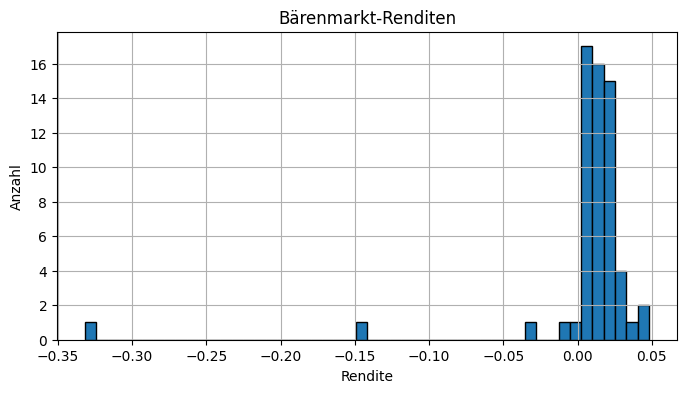

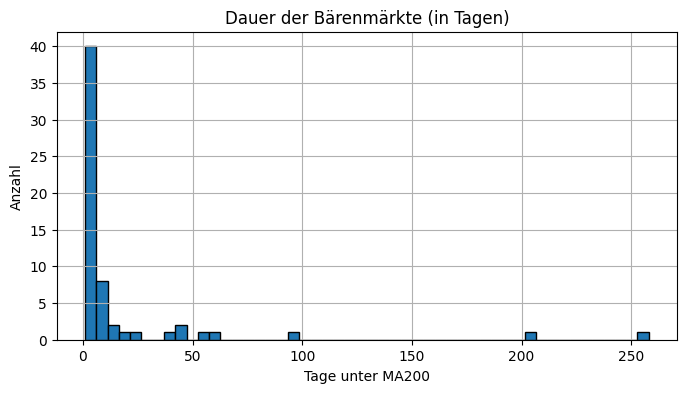

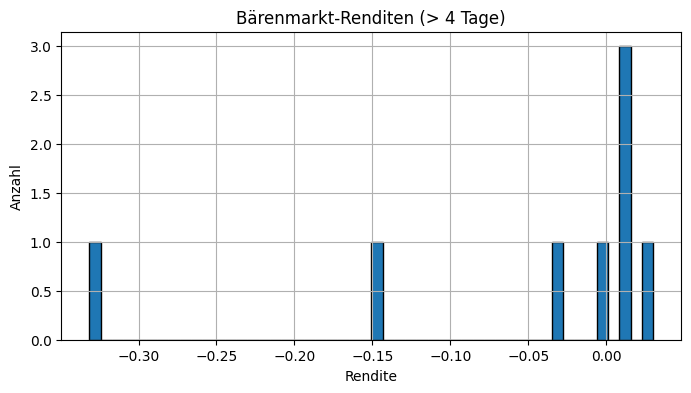

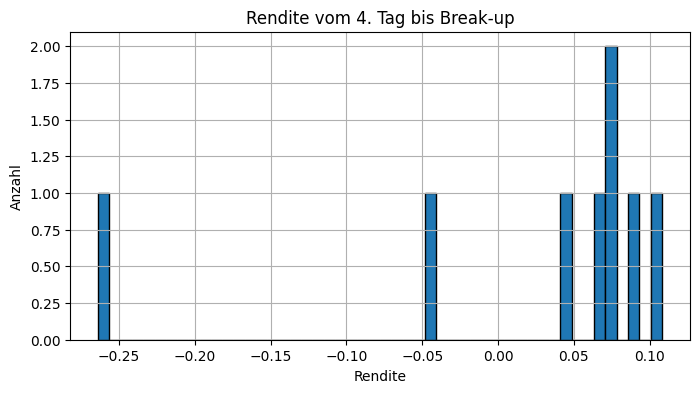

In [515]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten einlesen
spx = pd.read_csv("data/S&P 500 TR Historical Data.csv", parse_dates=["Date"])
spx["Price"] = spx["Price"].str.replace(",", "").astype(float)
spx = spx.iloc[::-1].reset_index(drop=True)

# 200‑Tage‑Schnitt und Bärenmarkt-Phasen
spx["MA200"] = spx["Price"].rolling(200).mean()
spx["bear"] = spx["Price"] < spx["MA200"]
spx["bear_prev"] = spx["bear"].shift(1).fillna(False).astype(bool)

# Übergänge
starts = spx.index[spx["bear"] & ~spx["bear_prev"]].tolist()
ends   = spx.index[~spx["bear"] & spx["bear_prev"]].tolist()

# Listen für Renditen und Dauer
returns = []
durations = []

for start in starts:
    future_ends = [e for e in ends if e > start]
    if not future_ends:
        break
    end = future_ends[0]
    ret = spx.loc[end, "Price"] / spx.loc[start, "Price"] - 1
    returns.append(ret)
    durations.append(end - start)

# Histogramm Renditen
plt.figure(figsize=(8, 4))
plt.hist(returns, bins=50, edgecolor='black')
plt.title("Bärenmarkt-Renditen")
plt.xlabel("Rendite")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()

# Histogramm Dauer
plt.figure(figsize=(8, 4))
plt.hist(durations, bins=50, edgecolor='black')
plt.title("Dauer der Bärenmärkte (in Tagen)")
plt.xlabel("Tage unter MA200")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()

# Filter auf Phasen > 4 Tage
long_phases = [(s, e) for s, e, d in zip(starts, ends, durations) if d > 30]

# Rendite von Break-down bis Break-up (nur lange Phasen)
returns_long = [spx.loc[e, "Price"] / spx.loc[s, "Price"] - 1
                for s, e in long_phases]

# Rendite vom Closing am 4. Tag bis zum Break-up
returns_from_day4 = [
    spx.loc[e, "Price"] / spx.loc[s + 28, "Price"] - 1
    for s, e in long_phases
]

# Histogramm: Renditen lange Bärenmärkte
plt.figure(figsize=(8, 4))
plt.hist(returns_long, bins=50, edgecolor='black')
plt.title("Bärenmarkt-Renditen (> 4 Tage)")
plt.xlabel("Rendite")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()

# Histogramm: Rendite ab 4. Tag bis Ende
plt.figure(figsize=(8, 4))
plt.hist(returns_from_day4, bins=50, edgecolor='black')
plt.title("Rendite vom 4. Tag bis Break-up")
plt.xlabel("Rendite")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()



In [583]:
import pandas as pd
import numpy as np

# Datei einlesen
df = pd.read_csv(
    'data/S&P 500 TR Historical Data.csv',
    sep=';',
    quotechar='"',
    thousands=','
)
df.head()
# Spaltennamen säubern
df.columns = df.columns.str.strip()

# Preis-Spalten in numerisch umwandeln
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Gold']  = pd.to_numeric(df['Gold'], errors='coerce')
df = df.iloc[::-1].reset_index(drop=True)
# Renditen berechnen
df['ret_spx']  = df['Price'].pct_change()
df['ret_gold'] = df['Gold'].pct_change()

# 200-Tage gleitender Durchschnitt auf SPX
df['ma200'] = df['Price'].rolling(200).mean()

# Einfaches Signal: nur Gold, wenn SPX über seinem MA200 war
signal = df['Price'].shift(1) > df['ma200'].shift(1)
df['ret_strat'] = np.where(signal, df['ret_spx']*3, df['ret_gold'])  # kannst du hier später variieren

# Portfolio simulieren
df['portfolio'] = 100 * (1 + df['ret_strat']).cumprod()

# Ergebnis
print(df[['Date', 'Price', 'Gold', 'ret_strat', 'portfolio']].tail())


            Date    Price    Gold  ret_strat    portfolio
4994  06/15/2021  8833.68  1855.2  -0.005928  5513.361122
4995  06/16/2021  8786.18  1860.2  -0.016131  5424.422655
4996  06/17/2021  8782.58  1774.5  -0.001229  5417.754937
4997  06/18/2021  8667.76  1768.4  -0.039221  5205.266139
4998  06/21/2021  8789.52  1782.3   0.042142  5424.628422


In [670]:
import pandas as pd
import numpy as np

# Datei einlesen
df = pd.read_csv(
    'data/All Historical Data.csv',
    sep=';',
    quotechar='"',
    thousands=','
)
df = df.iloc[::-1].reset_index(drop=True)
df["EM Return"] = df["EM Close"].pct_change()+ 0.00011
df["Stoxx Return"] = df["Stoxx 50 Close"].pct_change()* 2 + 0.00016
df["SPX Return"] = df["SPX Close"].pct_change()
df["Base Portfolio Return"] = df["SPX Return"] * 0.25 + df["Stoxx Return"]*0.4 + df["EM Return"] * 0.55

print(df.head())




         Date  SPX Close  SPX Open  SPX High  SPX Low  Nasdaq Close  \
0  01/30/2012    2256.72   2256.72   2256.72  2256.72        2596.2   
1  01/31/2012    2255.69   2255.69   2255.69  2255.69        2617.5   
2  02/01/2012    2276.24   2276.24   2276.24  2276.24        2625.5   
3  02/02/2012    2278.92   2278.92   2278.92  2278.92        2661.6   
4  02/03/2012    2312.49   2312.49   2312.49  2312.49        2660.9   

   Nasdaq Open  Nasdaq High  Nasdaq Low    Gold  Stoxx 50 Close  EM Close  \
0       2605.4       2610.5      2580.5  1680.6         2287.10    936.87   
1       2610.6       2627.1      2602.9  1660.2         2248.34    912.47   
2       2624.8       2634.3      2616.4  1649.7         2283.09    909.43   
3       2650.8       2664.9      2646.7  1651.1         2236.11    905.65   
4       2651.4       2660.9      2645.3  1639.6         2225.63    916.44   

     Vix  EM Return  Stoxx Return  SPX Return  Base Portfolio Return  
0  17.03        NaN           NaN      